In [20]:
import pandas as pd

In [21]:
train = pd.read_pickle("/Users/rui/Documents/repositories/m5_forecasting_accuracy/v01000/features/add_weight.pkl")

In [22]:
train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,price_MIN,price_STD,price_MEAN,price_NORM,price_NUNIQUE,item_NUNIQUE,price_momentum,price_momentum_month,price_momentum_year,weight
0,HOBBIES_1_008_CA_1_validation,1444,3,1,0,0,d_1,12,2011-01-29,11101,...,0.419922,0.019791,0.476318,0.919922,4.0,16.0,NaN,0.982422,0.950195,NaN
1,HOBBIES_1_009_CA_1_validation,1445,3,1,0,0,d_1,2,2011-01-29,11101,...,1.559570,0.032715,1.764648,0.881348,2.0,9.0,NaN,0.899414,0.896484,NaN
2,HOBBIES_1_010_CA_1_validation,1446,3,1,0,0,d_1,0,2011-01-29,11101,...,2.970703,0.046173,2.982422,1.000000,2.0,20.0,NaN,1.055664,1.043945,NaN
3,HOBBIES_1_012_CA_1_validation,1448,3,1,0,0,d_1,0,2011-01-29,11101,...,5.980469,0.115906,6.468750,0.917480,3.0,71.0,NaN,0.930176,0.959473,NaN
4,HOBBIES_1_015_CA_1_validation,1451,3,1,0,0,d_1,4,2011-01-29,11101,...,0.680176,0.011353,0.707031,0.972168,3.0,16.0,NaN,0.989746,1.001953,NaN


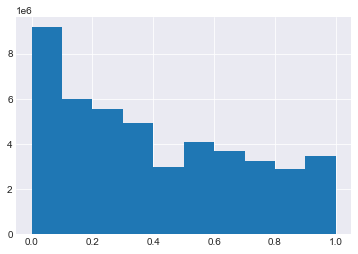

In [23]:
train['weight'].hist()

In [24]:
from sklearn.metrics import mean_squared_error

def rmsle(preds, actual, weight=None):
    return mean_squared_error(
        np.log1p(actual), np.log1p(preds), sample_weight=weight, squared=False)

In [25]:
import numpy as np
pred = train['sales'] + np.random.randint(3, size=train.shape[0])
acutual = train['sales']
weight = train['weight']

In [26]:
rmsle(pred, acutual, None)

0.6253280105443956

In [27]:
import os
import gc
import re
import pickle
import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd

from typing import Union

import seaborn
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

from scipy.stats import linregress

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

VERSION = 1000

In [33]:

''' Train Model
'''

def split_train_eval_submit(df, pred_interval=28):
    latest_date = df['date'].max()
    submit_date = latest_date - datetime.timedelta(days=pred_interval)
    submit_mask = (df["date"] > submit_date)

    eval_date = latest_date - datetime.timedelta(days=pred_interval * 2)
    eval_mask = ((df["date"] > eval_date) & (df["date"] <= submit_date))

    train_mask = ((~eval_mask) & (~submit_mask))
    return df[train_mask], df[eval_mask], df[submit_mask]


def plot_cv_indices(cv, X, y, dt_col, lw=10):
    n_splits = cv.get_n_splits()
    fig, ax = plt.subplots(figsize=(20, n_splits))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            X[dt_col],
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    MIDDLE = 15
    LARGE = 20
    ax.set_xlabel("Datetime", fontsize=LARGE)
    ax.set_xlim([X[dt_col].min(), X[dt_col].max()])
    ax.set_ylabel("CV iteration", fontsize=LARGE)
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=MIDDLE)
    ax.set_title("{}".format(type(cv).__name__), fontsize=LARGE)
#     fig.savefig(f"result/cv_split/{VERSION}.png")


class CustomTimeSeriesSplitter:
    def __init__(self, n_splits=5, train_days=80, test_days=20, dt_col="date"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.dt_col = dt_col

    def split(self, X, y=None, groups=None):
        sec = (X[self.dt_col] - X[self.dt_col][0]).dt.total_seconds()
        duration = sec.max() - sec.min()

        train_sec = 3600 * 24 * self.train_days
        test_sec = 3600 * 24 * self.test_days
        total_sec = test_sec + train_sec
        step = (duration - total_sec) / (self.n_splits - 1)

        for idx in range(self.n_splits):
            train_start = idx * step
            train_end = train_start + train_sec
            test_end = train_end + test_sec

            if idx == self.n_splits - 1:
                test_mask = sec >= train_end
            else:
                test_mask = (sec >= train_end) & (sec < test_end)

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = (sec >= train_end) & (sec < test_end)

            yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self):
        return self.n_splits


def get_feature_importance(models):
    feature_importance = pd.DataFrame(
        [model.feature_importance() for model in models],
        columns=models[0].feature_name()
    ).T

    feature_importance['Agerage_Importance'] = feature_importance.iloc[:, :len(models)].mean(axis=1)
    feature_importance['importance_std'] = feature_importance.iloc[:, :len(models)].std(axis=1)
    feature_importance.sort_values(by='Agerage_Importance', inplace=True)
    return feature_importance


def plot_importance(models, max_num_features=50, figsize=(15, 20)):
    feature_importance = get_feature_importance(models)
    plt.figure(figsize=figsize)

    feature_importance[-max_num_features:].plot(
        kind='barh', title='Feature importance', figsize=figsize,
        y='Agerage_Importance', xerr='importance_std',
        grid=True, align="center"
    )
    plt.savefig(f'result/importance/{VERSION}.png')
    plt.close()


def rmsle(preds, actual, weight=None):
    return mean_squared_error(
        np.log1p(actual), np.log1p(preds), sample_weight=weight, squared=False)


def lgbm_rmsle(preds, data):
    weight = None  # data.get_weight()
    actual = data.get_label()
    metric_name = 'RMSLE' if weight is None else 'WRMSLE'
    return metric_name, rmsle(preds, actual, weight), False


def train_lgb(bst_params, fit_params, X, y, cv, drop_when_train=[]):
    models = []
    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n{idx_fold + 1} of {cv.get_n_splits()} Fold:\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        train_set = lgb.Dataset(X_trn.drop(drop_when_train, axis=1), label=y_trn, weight=X_trn['weight'])
        val_set = lgb.Dataset(X_val.drop(drop_when_train, axis=1), label=y_val, weight=X_val['weight'])

        model = lgb.train(
            bst_params,
            train_set,
            valid_sets=[train_set, val_set],
            valid_names=["train", "valid"],
            **fit_params,
            feval=lgbm_rmsle,
        )
        models.append(model)

        del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
        gc.collect()

    plot_importance(models)
    return models



--- Train Model ---

Cross Validation Parameters:
{'n_splits': 5, 'train_days': 730, 'test_days': 90, 'dt_col': 'date'} 



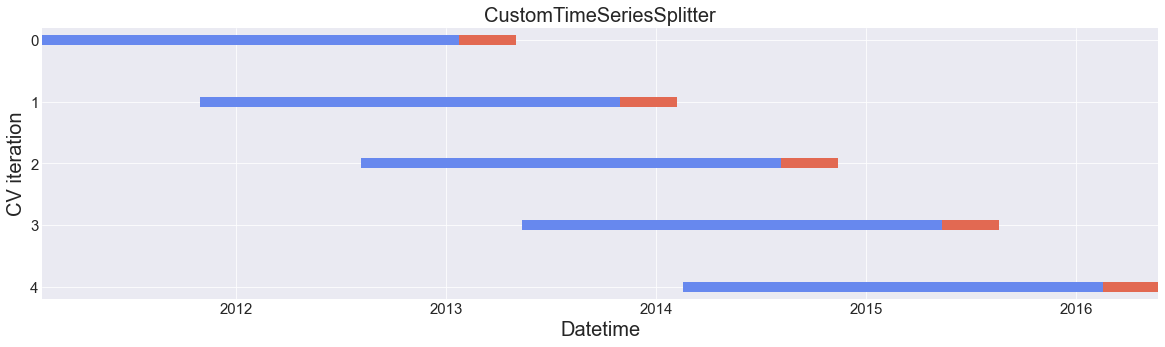

In [34]:
print('\n--- Train Model ---\n')
'''TODO: こっからリファクタリングの続き'''
cv_params = {
    "n_splits": 5,
    "train_days": 365 * 2,
    "test_days": 90,
    "dt_col": 'date',
}
print('Cross Validation Parameters:')
print(cv_params, '\n')
cv = CustomTimeSeriesSplitter(**cv_params)
# Plotting all the points takes long time.
plot_cv_indices(cv, train.iloc[::1000][['date']].reset_index(drop=True), None, 'date')

In [52]:
# Split train, eval, submit data.
target_col = 'sales'
features = train.columns.tolist()
cols_to_drop = ['id', 'wm_yr_wk', 'd', 'date'] + [target_col]
features = [f for f in features if f not in cols_to_drop]

train[features] = train[features].fillna(-1)

train_data, eval_data, submit_data = split_train_eval_submit(train)
# del train; gc.collect()

In [53]:
print('train_data:')
print(train_data.shape)
display(train_data.head())

print('eval_data:')
print(eval_data.shape)
display(eval_data.head())

print('submit_data:')
print(submit_data.shape)
display(submit_data.head())

train_data:
(45174237, 52)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,price_MIN,price_STD,price_MEAN,price_NORM,price_NUNIQUE,item_NUNIQUE,price_momentum,price_momentum_month,price_momentum_year,weight
0,HOBBIES_1_008_CA_1_validation,1444,3,1,0,0,d_1,12,2011-01-29,11101,...,0.419922,0.019791,0.476318,0.919922,4.0,16.0,-1.0,0.982422,0.950195,0.0
1,HOBBIES_1_009_CA_1_validation,1445,3,1,0,0,d_1,2,2011-01-29,11101,...,1.559570,0.032715,1.764648,0.881348,2.0,9.0,-1.0,0.899414,0.896484,0.0
2,HOBBIES_1_010_CA_1_validation,1446,3,1,0,0,d_1,0,2011-01-29,11101,...,2.970703,0.046173,2.982422,1.000000,2.0,20.0,-1.0,1.055664,1.043945,0.0
3,HOBBIES_1_012_CA_1_validation,1448,3,1,0,0,d_1,0,2011-01-29,11101,...,5.980469,0.115906,6.468750,0.917480,3.0,71.0,-1.0,0.930176,0.959473,0.0
4,HOBBIES_1_015_CA_1_validation,1451,3,1,0,0,d_1,4,2011-01-29,11101,...,0.680176,0.011353,0.707031,0.972168,3.0,16.0,-1.0,0.989746,1.001953,0.0


eval_data:
(853720, 52)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,price_MIN,price_STD,price_MEAN,price_NORM,price_NUNIQUE,item_NUNIQUE,price_momentum,price_momentum_month,price_momentum_year,weight
45174237,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1886,1,2016-03-28,11609,...,8.257812,0.152344,8.281250,0.862305,3.0,5.0,1.0,0.996094,0.993652,0.714355
45174238,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1886,1,2016-03-28,11609,...,3.970703,0.000000,3.970703,1.000000,1.0,131.0,1.0,1.000000,1.000000,0.357178
45174239,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1886,0,2016-03-28,11609,...,2.970703,0.000000,2.970703,1.000000,1.0,118.0,1.0,1.000000,1.000000,0.321533
45174240,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1886,0,2016-03-28,11609,...,4.339844,0.145630,4.527344,1.000000,2.0,2.0,1.0,1.023438,1.000000,0.678711
45174241,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1886,1,2016-03-28,11609,...,2.480469,0.150024,2.941406,0.935547,4.0,161.0,1.0,0.967773,1.000000,0.678711


submit_data:
(853720, 52)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,price_MIN,price_STD,price_MEAN,price_NORM,price_NUNIQUE,item_NUNIQUE,price_momentum,price_momentum_month,price_momentum_year,weight
46027957,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1914,0,2016-04-25,11613,...,8.257812,0.152344,8.281250,0.875000,3.0,7.0,1.0,1.011719,1.008789,0.535645
46027958,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1914,0,2016-04-25,11613,...,3.970703,0.000000,3.970703,1.000000,1.0,131.0,1.0,1.000000,1.000000,0.035706
46027959,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1914,0,2016-04-25,11613,...,2.970703,0.000000,2.970703,1.000000,1.0,118.0,1.0,1.000000,1.000000,0.464355
46027960,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1914,0,2016-04-25,11613,...,4.339844,0.145630,4.527344,1.000000,2.0,2.0,1.0,1.023438,1.000000,0.678711
46027961,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1914,0,2016-04-25,11613,...,2.480469,0.150024,2.941406,0.935547,4.0,161.0,1.0,0.967773,1.000000,0.714355


In [54]:
bst_params = {
    "boosting_type": "gbdt",
    "metric": "None",  # "rmse",
    "objective": "poisson",
    "seed": 11,
    "learning_rate": 0.3,
    'max_depth': 7,
    'num_leaves': 128,
    'min_data_in_leaf': 50,
    "bagging_fraction": 0.8,
    "bagging_freq": 10,
    "feature_fraction": 0.8,
    "verbosity": -1,
}

fit_params = {
    "num_boost_round": 100000,
    "early_stopping_rounds": 50,
    "verbose_eval": 100,
}
print('Model Parameters:')
print(bst_params)

Model Parameters:
{'boosting_type': 'gbdt', 'metric': 'None', 'objective': 'poisson', 'seed': 11, 'learning_rate': 0.3, 'max_depth': 7, 'num_leaves': 128, 'min_data_in_leaf': 50, 'bagging_fraction': 0.8, 'bagging_freq': 10, 'feature_fraction': 0.8, 'verbosity': -1}


In [55]:
models = train_lgb(
    bst_params, fit_params,
    train_data[['date'] + features], train_data[target_col],
    cv, drop_when_train=['date', 'weight']
)


Fold: (1 / 5)

Training until validation scores don't improve for 50 rounds
[100]	train's RMSLE: 0.747728	valid's RMSLE: 0.761706


KeyboardInterrupt: 